## Compare count-in-cells PDF model with DESI Y1 mock

In [1]:
import ctypes
import os
import time
import matplotlib.pyplot as plt
import numpy as np

import healpy as hp
import mpytools as mpy
from pypower.utils import sky_to_cartesian
from mockfactory import Catalog, RedshiftDensityInterpolator, utils
from cic_density import compute_cic_density, compute_cic_density_survey, get_rdd
from cosmomentum_density_pdf_model import compute_density_pdf

plt.style.use(os.path.join(os.path.abspath('./'), 'plot_style.mplstyle'))

g++ -std=c++0x  -L/usr/local/lib/ -I/usr/local/include -shared -o DSS.so -fPIC python_interfaces.cpp -lgsl -lgslcblas -pthread -O3 -Wuninitialized


In file included from GalaxySample.h:58,
                 from GalaxySample3D.h:3,
                 from python_interfaces.cpp:9:
GalaxySample.cpp: In member function 'std::vector<double> GalaxySample::return_CIC_from_matter_density_PDF(double, std::vector<std::vector<double> >)':
GalaxySample.cpp:264:67: warning: 'delta_g' may be used uninitialized in this function [-Wmaybe-uninitialized]
  264 |       P_of_N_given_delta[n][d] = this->return_P_of_N_given_delta_g(n, N_bar, PDF_data[0][d], delta_g);
      |                                  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from FlatInhomogeneousUniverseLCDM.h:221,
                 from python_interfaces.cpp:8:
FlatInhomogeneousUniverseLCDM.cpp: In member function 'std::vector<std::vector<double> > FlatInhomogeneousUniverseLCDM::compute_phi_tilde_of_lambda_2D(double, double, double, double)':
FlatInhomogeneousUniverseLCDM.cpp:1247:18: warning: 'dskew_L_RL_dR' may be used uninitialized i

## DESI Y1 mocks

In [14]:
from cosmoprimo import fiducial
cosmo = fiducial.DESI()

nmocks=25
tracer = "ELG"
completeness = 'complete_'
region = 'S'
z_avg = {'ELG': 1.1, 'LRG': 0.8, 'QSO': 1.4}
z = z_avg[tracer]

## Smoothing parameters

In [15]:
# Density smoothing parameters
cellsize = 30
R = cellsize / 2

In [16]:
th = 5

#density_cic = compute_cic_density_survey(tracer, completeness, region=region, smoothing_radius=R, cellsize=cellsize, th=th, nmocks=nmocks, use_rsd=False)
density_cic = np.load('density_cic_{}mocks_{}_{}_{}_R{}Mpc_{}th.npy'.format(nmocks, tracer, completeness, region, R, th))

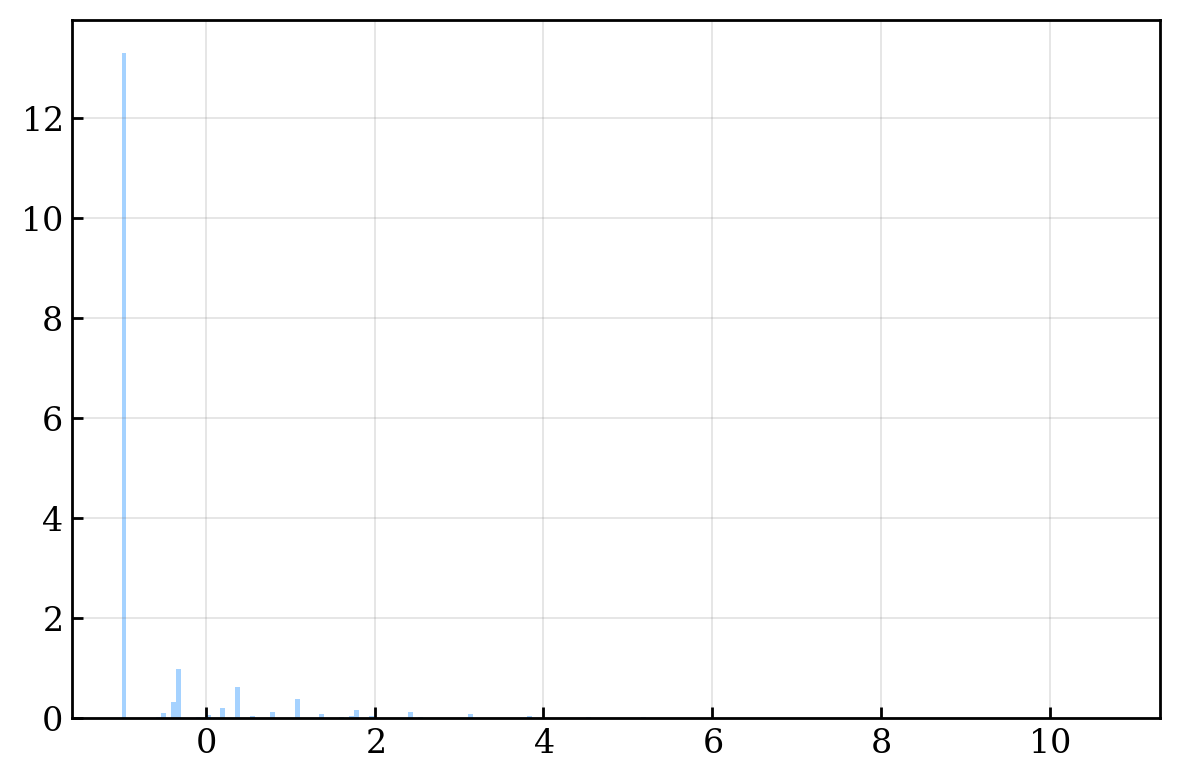

In [17]:
fig = plt.figure(figsize=(6, 4))
plt.hist(density_cic , bins=200, density=True, alpha=0.4, label='Count-in-cells')
plt.show()

In [6]:
delta_values, PDF_values = compute_density_pdf(cosmo, z, smoothing_radius = R)

NOTE: in FlatHomogeneousUniverseLCDM::set_initial_conditions(): initial conditions module assumes flat universe!
WARNING in FlatInhomogeneousUniverseLCDM::set_initial_conditions(): growth factor is computed for matter density fluctuations and all other components are assumed to be homogeneous!
Setting sphere variances.
Setting cylinder variances.
Setting spherical collapse evolution.
Setting cylindrical collapse evolution.
Done.
Initialising primordial skewnesses from power law approximation
eps3(R) = skewness(R)/sigma(R)^3 = A_eps3*(R/R_0)^n_eps3 .
Computing CGF_data:
Computing CGF_data done.
Done.
Computing tau coefficients:
Done.
Computing PDF:
3.1861   5.3282e-07            

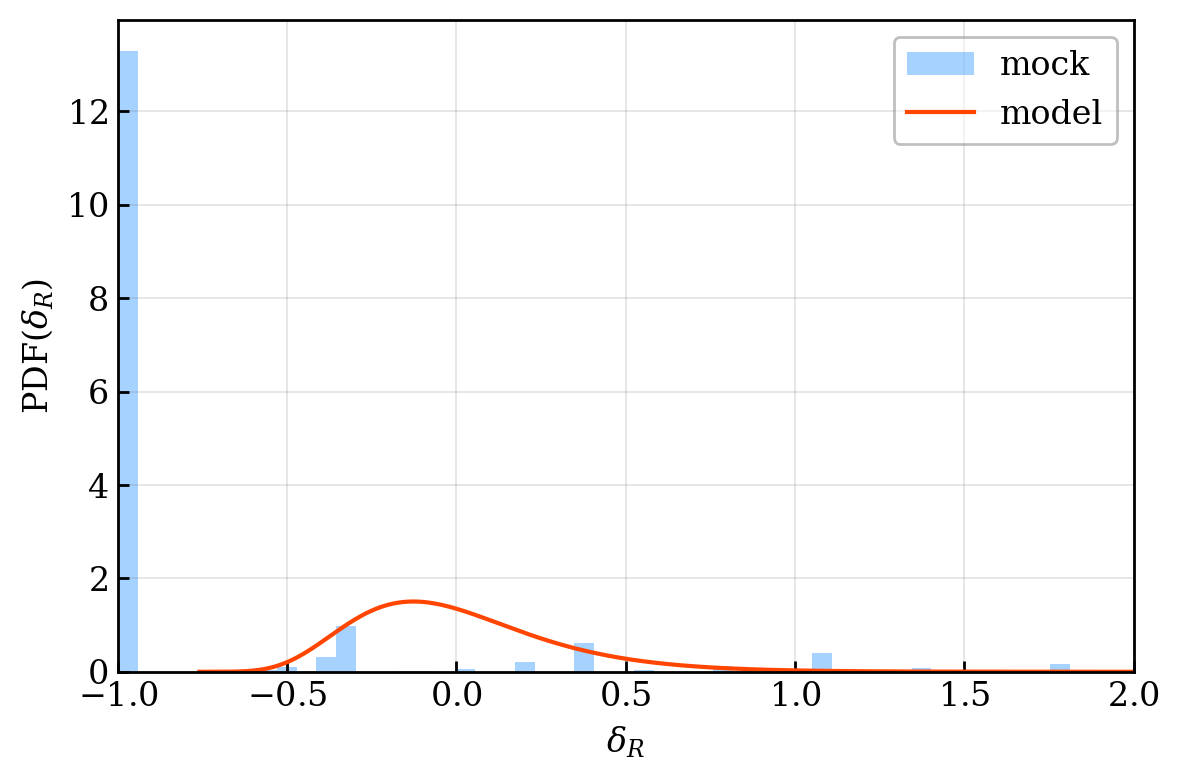

In [18]:
plt.hist(np.ravel(density_cic), bins=200, density=True, alpha=0.4, label='mock')
plt.plot(delta_values, PDF_values, linestyle='solid', label='model')
var = np.sum(delta_values**2*PDF_values)/np.sum(PDF_values)
plt.xlim(-1.0, 2)

plt.legend()
plt.xlabel(r'$\delta_R$')
plt.ylabel(r'$\mathrm{PDF}(\delta_R)$')
plt.savefig('CosMomentum_vs_Abacus_density.pdf', dpi=200)
plt.show()

In [3]:
# NORTH
data_N_fn = "/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FirstGenMocks/AbacusSummit/Y1v1/mock{:d}/LSScats/{}_{}N_clustering.dat.fits".format(imock, tracer, completeness)
randoms_N_fn = "/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FirstGenMocks/AbacusSummit/Y1v1/mock{:d}/LSScats/{}_{}N_0_clustering.ran.fits".format(imock, tracer, completeness)
data_N = Catalog.read(data_N_fn, filetype='fits')
randoms_N = Catalog.read(randoms_N_fn, filetype='fits')

# SOUTH
data_S_fn = "/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FirstGenMocks/AbacusSummit/Y1v1/mock{:d}/LSScats/{}_{}S_clustering.dat.fits".format(imock, tracer, completeness)
randoms_S_fn = "/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FirstGenMocks/AbacusSummit/Y1v1/mock{:d}/LSScats/{}_{}S_0_clustering.ran.fits".format(imock, tracer, completeness)
data_S = Catalog.read(data_S_fn, filetype='fits')
randoms_S = Catalog.read(randoms_S_fn, filetype='fits')

zlim = {'ELG': (0.8, 1.6), 'LRG':(0.4, 1.1), 'QSO':(0.8, 3.5)}
data_S = data_S[(data_S['Z'] > zlim[tracer][0]) & (data_S['Z'] < zlim[tracer][1])]
randoms_S = randoms_S[(randoms_S['Z'] > zlim[tracer][0]) & (randoms_S['Z'] < zlim[tracer][1])]

In [4]:
data_positions = sky_to_cartesian(get_rdd(data_S))
randoms_positions = sky_to_cartesian(get_rdd(randoms_S))
data_weights = data_S['WEIGHT']
randoms_weights = randoms_S['WEIGHT']

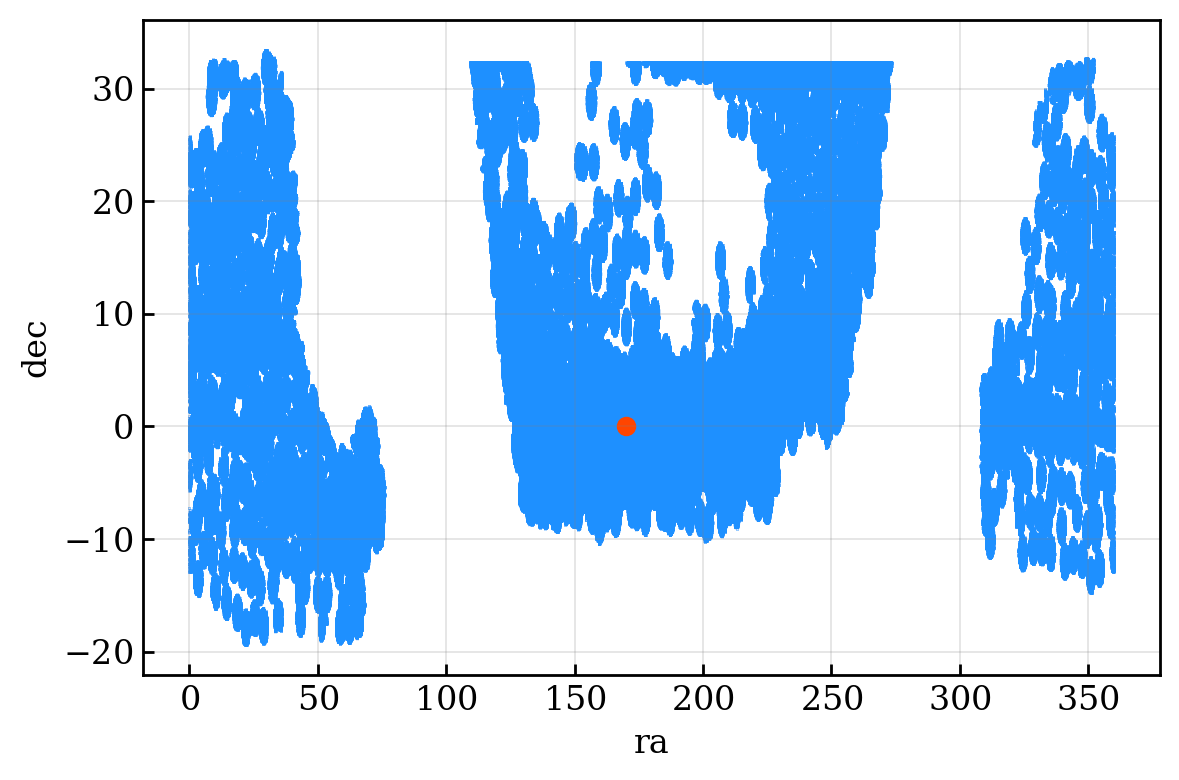

In [5]:
fig = plt.figure(figsize=(6, 4))
plt.scatter(randoms_S['RA'][::], randoms_S['DEC'][::], marker='.', s=0.01, alpha=0.3)
middle_point = sky_to_cartesian([170, 0, cosmo.comoving_radial_distance(1.1)])
plt.scatter(170, 0, color='orangered')
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

In [7]:
pos = np.array(data_positions)
boxsize = np.max(pos, axis=1) - np.min(pos, axis=1)
nmesh = np.int32(boxsize / cellsize)

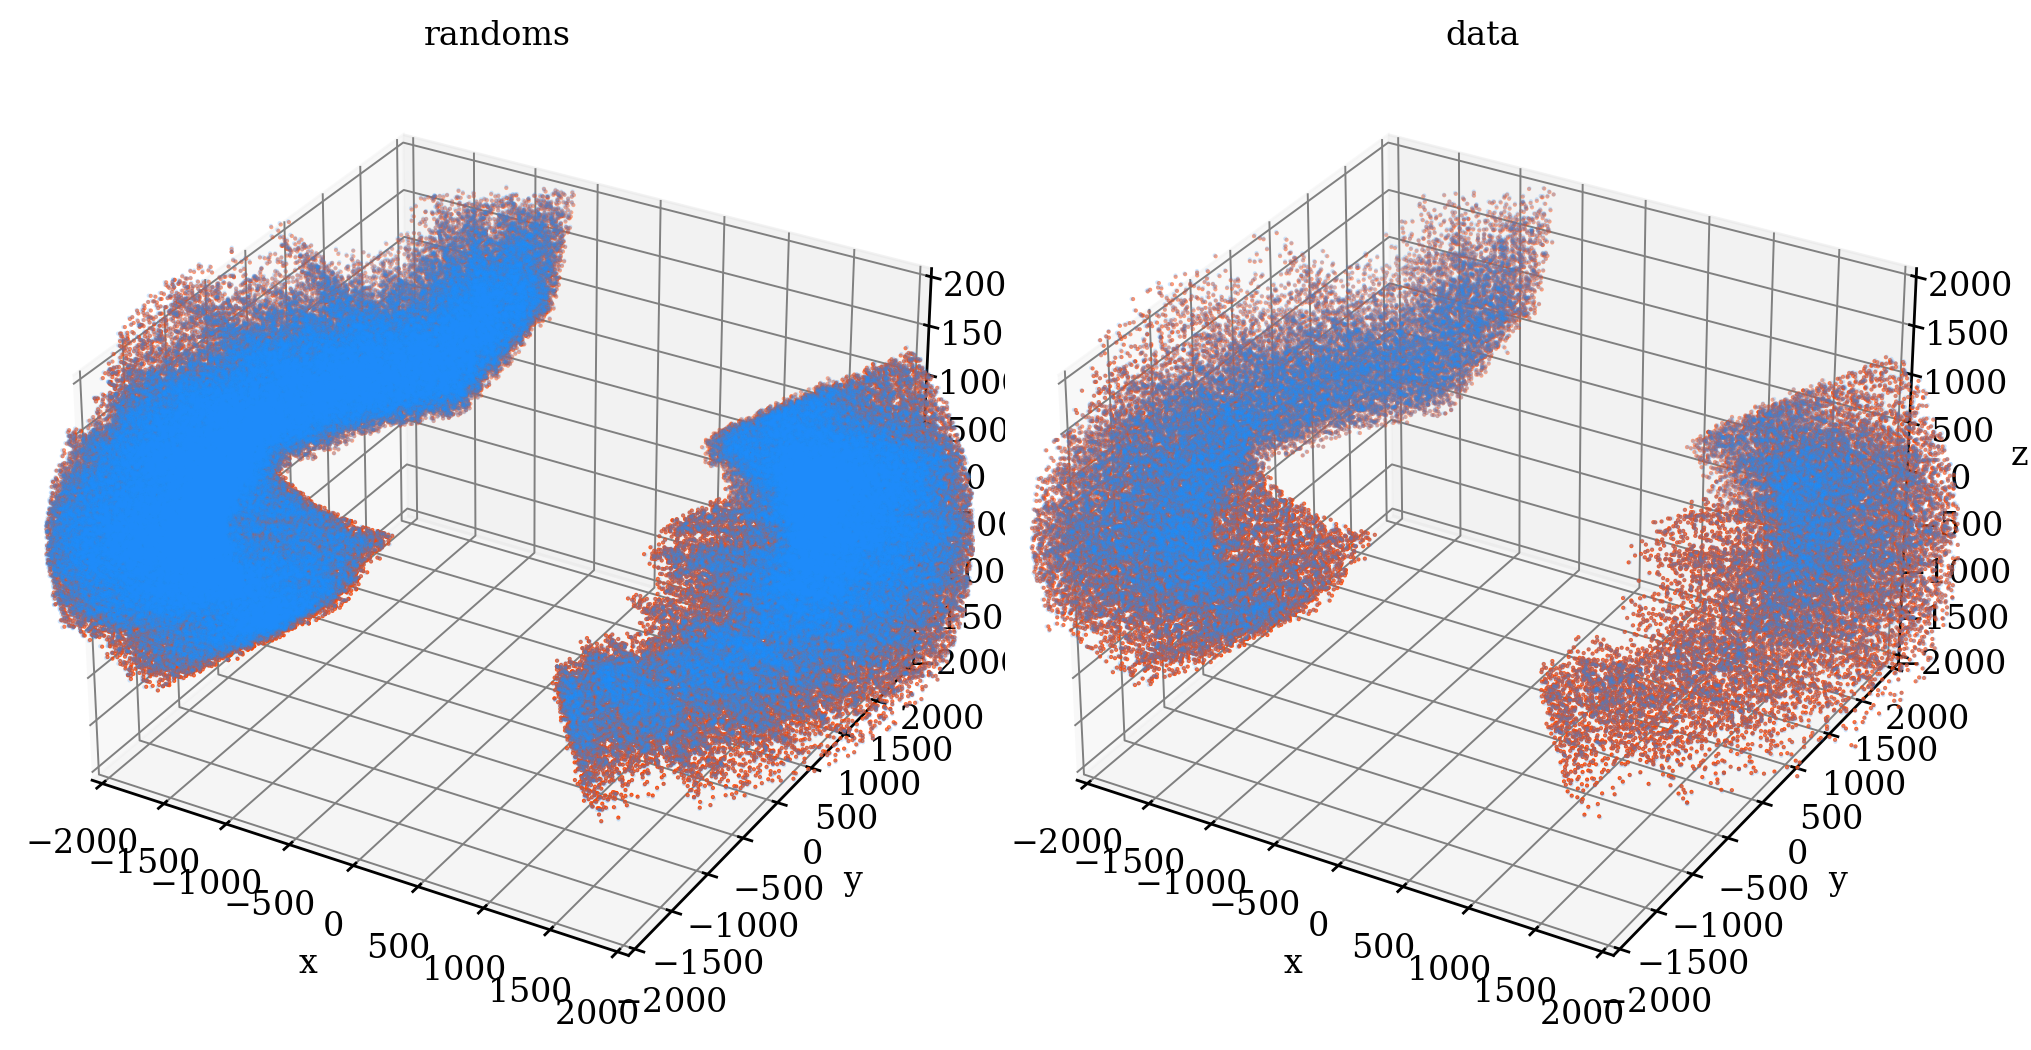

In [8]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121, projection='3d', title='randoms')
pos = np.array(randoms_positions)
indices_in_grid = np.int32(pos / cellsize)
grid_pos = indices_in_grid * cellsize
dist_to_nearest_node = np.sum((grid_pos - pos)**2, axis=0)**0.5
mask_particles = dist_to_nearest_node < R
ax.scatter(randoms_positions[0][mask_particles][::10], randoms_positions[1][mask_particles][::10], randoms_positions[2][mask_particles][::10], s=randoms_weights[mask_particles][::10]/np.max(randoms_weights[::10]), marker='.', alpha=0.2)
ax.scatter(grid_pos[0][mask_particles][::10], grid_pos[1][mask_particles][::10], grid_pos[2][mask_particles][::10], s=1, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d(-2000, 2000)
ax.set_ylim3d(-2000, 2000)
ax.set_zlim3d(-2000, 2000)
ax = fig.add_subplot(122, projection='3d', title='data')
pos = np.array(data_positions)
indices_in_grid = np.int32(pos / cellsize)
grid_pos = indices_in_grid * cellsize
dist_to_nearest_node = np.sum((grid_pos - pos)**2, axis=0)**0.5
mask_particles = dist_to_nearest_node < R
ax.scatter(data_positions[0][mask_particles][::10], data_positions[1][mask_particles][::10], data_positions[2][mask_particles][::10], s=data_weights[mask_particles][::10]/np.max(data_weights[::10]), marker='.', alpha=0.2)
ax.scatter(grid_pos[0][mask_particles][::10], grid_pos[1][mask_particles][::10], grid_pos[2][mask_particles][::10], s=1, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d(-2000, 2000)
ax.set_ylim3d(-2000, 2000)
ax.set_zlim3d(-2000, 2000)
plt.show()

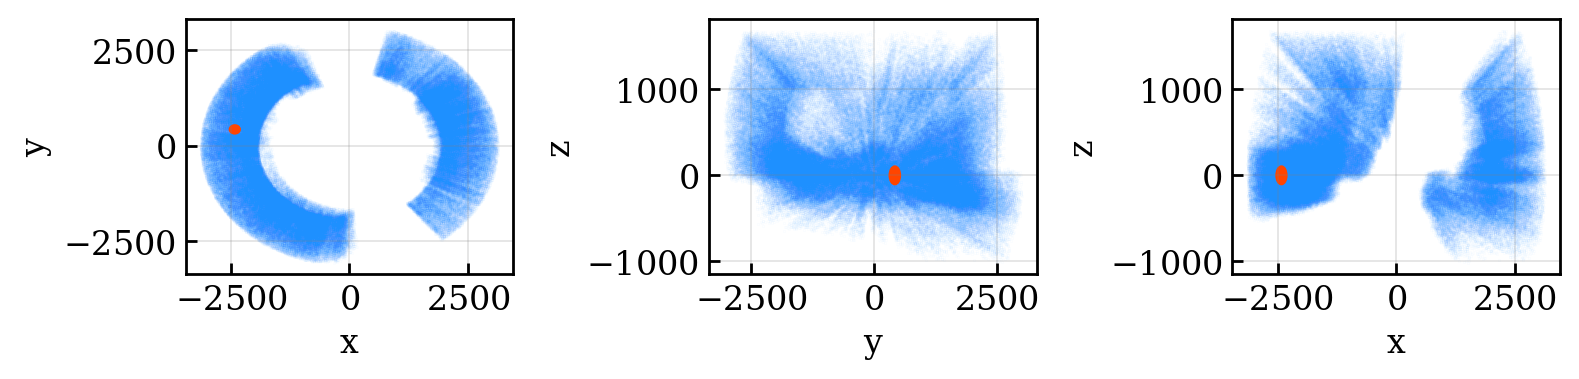

In [9]:
#middle_point = np.array([-2300, 0, 0])[:, None]
middle_point = np.array(middle_point)[:, None]

fig = plt.figure(figsize=(8, 2))
ax = fig.add_subplot(131)
ax.scatter(randoms_positions[0][::100], randoms_positions[1][::100], marker='.', s=0.01, alpha=0.1)
#ax.scatter(middle_point[0], middle_point[1])
circle = plt.Circle((middle_point[0], middle_point[1]), 100, color='orangered')
ax.add_patch(circle)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = fig.add_subplot(132)
ax.scatter(randoms_positions[1][::100], randoms_positions[2][::100], marker='.', s=0.01, alpha=0.1)
#ax.scatter(middle_point[1], middle_point[2])
circle = plt.Circle((middle_point[1], middle_point[2]), 100, color='orangered')
ax.add_patch(circle)
ax.set_xlabel('y')
ax.set_ylabel('z')

ax = fig.add_subplot(133)
ax.scatter(randoms_positions[0][::100], randoms_positions[2][::100], marker='.', s=0.01, alpha=0.1)
#ax.scatter(middle_point[0], middle_point[2])
circle = plt.Circle((middle_point[0], middle_point[2]), 100, color='orangered')
ax.add_patch(circle)
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.show()

In [10]:
N_randoms_in_cell = list()
expected_N_randoms_in_cell = list()

boxsize = np.max(np.array(data_positions), axis=1) - np.min(np.array(data_positions), axis=1)
pos = np.array(randoms_positions)
dist_to_nearest_node = np.sum((middle_point - pos)**2, axis=0)**0.5

cellsizes = np.linspace(10, 30, 100)
for cellsize in cellsizes:
    nmesh = np.int32(boxsize / cellsize)

    R = cellsize / 2
    mask_particles = dist_to_nearest_node < R
    N_randoms_in_cell.append(np.sum(randoms_weights[mask_particles]))
    expected_N_randoms_in_cell.append(1.6e-3 * 2 * 4/3 * np.pi * R**3)

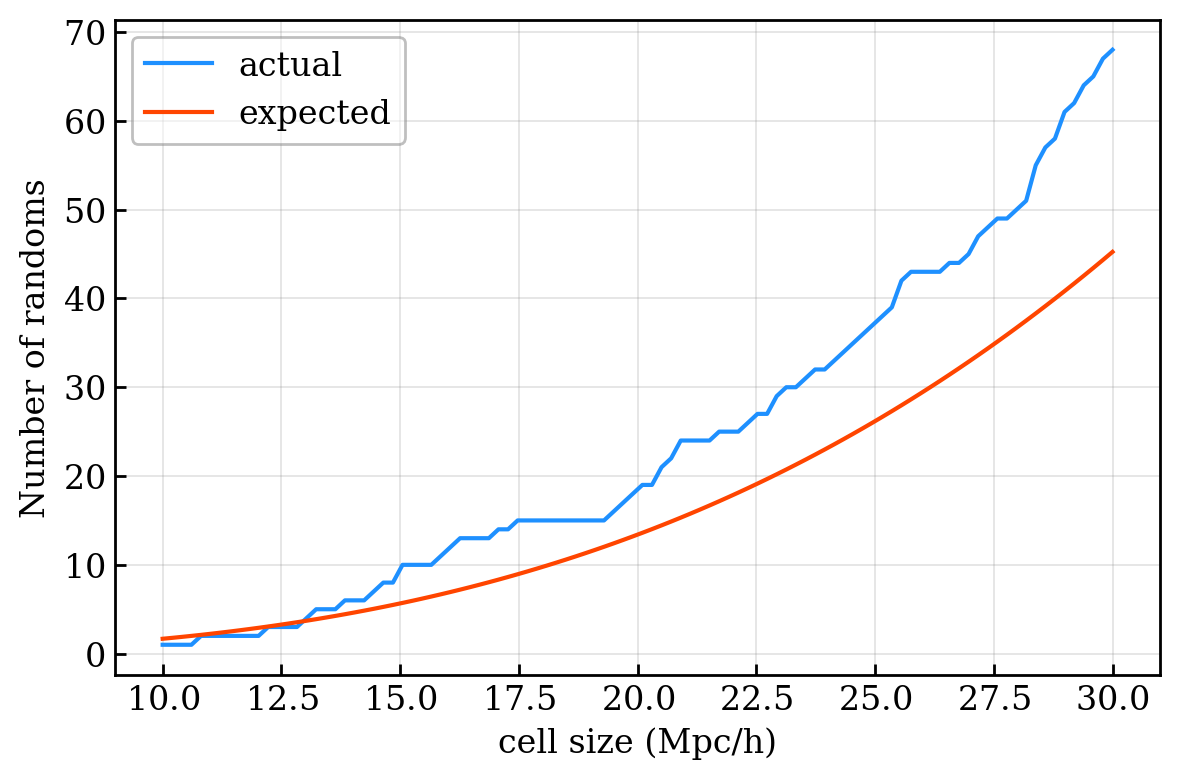

In [11]:
plt.plot(cellsizes, np.array(N_randoms_in_cell), label='actual')
plt.plot(cellsizes, np.array(expected_N_randoms_in_cell), label='expected')

plt.xlabel('cell size (Mpc/h)')
plt.ylabel('Number of randoms')
plt.legend()
plt.show()

## Compute count-in-cells density

In [12]:
# Density smoothing parameters
cellsize = 100
R = cellsize / 2

In [13]:
def compute_cic_density_survey_test(data_positions, randoms_positions, smoothing_radius, data_weights=None, randoms_weights=None, 
                               cellsize=None, use_rsd=False):    

    if cellsize is None:
        cellsize = smoothing_radius * 2
    else:
        if cellsize < 2 * smoothing_radius:
            print("Cellsize must be bigger than twice the smoothing radius.")
    offset = np.min(data_positions, axis=1)
    boxsize = np.max(data_positions, axis=1) - offset
            
    def compute_density_mesh(pos, weights=None):
        pos = pos - offset[:, None]
        indices_in_grid = np.int32(pos / cellsize)
        grid_pos = indices_in_grid * cellsize
        dist_to_nearest_node = np.sum((grid_pos - pos)**2, axis=0)**0.5
        mask_particles = dist_to_nearest_node < smoothing_radius
        
        nmesh = np.int32(boxsize / cellsize)
        mesh = np.zeros(nmesh, dtype='f8')
        mask_particles &= np.all(indices_in_grid < nmesh[:, None], axis=0)
        np.add.at(mesh, tuple(indices_in_grid[:, mask_particles]), weights[mask_particles] if (weights is not None) else 1.)
        return mesh
        
    data_mesh = compute_density_mesh(data_positions, data_weights)
    randoms_mesh = compute_density_mesh(randoms_positions, randoms_weights)
    #return data_mesh
    mesh = np.zeros_like(data_mesh)
    th = 0
    non_zeros_indices = np.logical_and(data_mesh != 0, randoms_mesh > th)
    nan_indices = np.where(randoms_mesh <= th)
    mesh[non_zeros_indices] = data_mesh[non_zeros_indices] * randoms_weights.csum() / (randoms_mesh[non_zeros_indices] * data_weights.csum())
    mesh[nan_indices] = np.nan
    return mesh - 1

In [14]:
density_cic = compute_cic_density_survey_test(np.array(data_positions), np.array(randoms_positions), R, data_weights, randoms_weights,
                                              cellsize=cellsize, use_rsd=False)

In [15]:
density_cic.shape

(62, 60, 27)

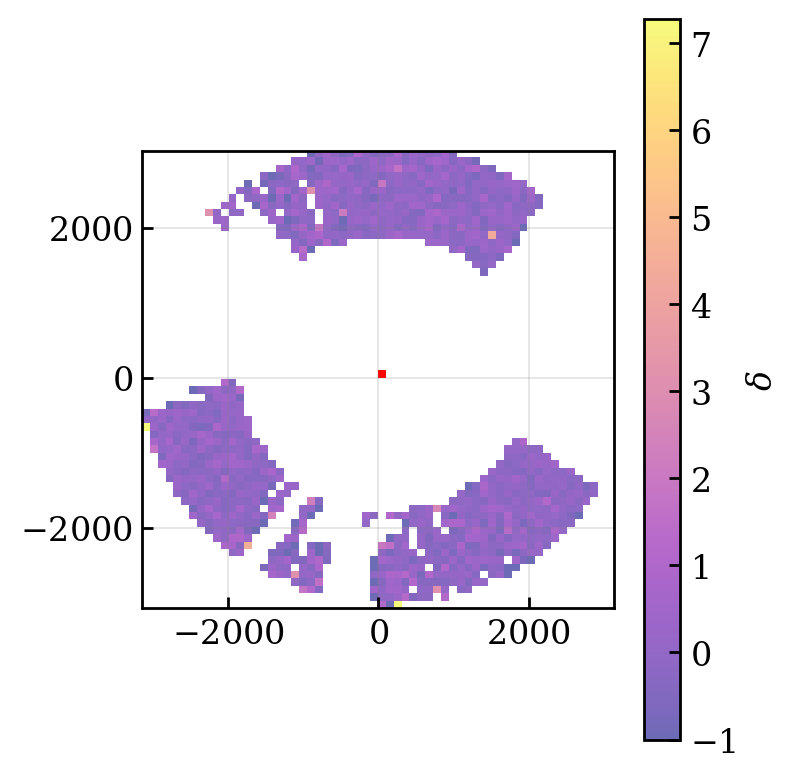

In [16]:
extent = np.min(data_positions[0]), np.max(data_positions[0]), np.min(data_positions[1]), np.max(data_positions[1])
fig = plt.figure(figsize=(4, 4))
c = plt.imshow(density_cic[:, :, 15], alpha=0.6, origin='lower', extent=extent)
ax = plt.gca()
ax.add_patch(plt.Rectangle((0, 0), cellsize, cellsize, facecolor='red'))
fig.colorbar(c, label='$\delta$')
plt.show()

In [17]:
density_cic = density_cic[~np.isnan(density_cic)]

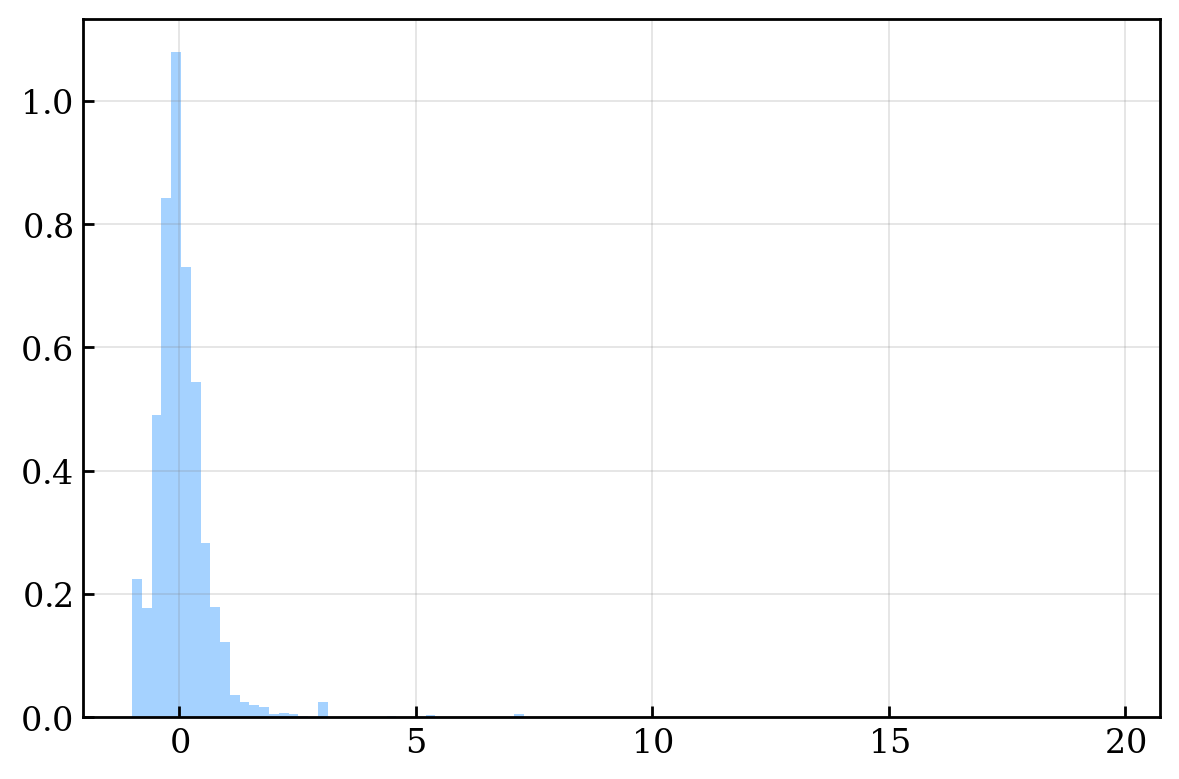

In [18]:
plt.hist(np.ravel(density_cic), bins=100, density=True, alpha=0.4, label='Count-in-cells')
#plt.hist(np.ravel(density_cic[density_cic>-1.]), bins=np.linspace(-1., 3., 100), density=True, alpha=0.4, label='Count-in-cells')
#plt.xlim(-1, 1.5)
plt.show()

### Compute n(z)

In [19]:
mpicomm = data_S.mpicomm
nside = 256
theta, phi = np.radians(90 - randoms_S['DEC']), np.radians(randoms_S['RA'])
hpindex = hp.ang2pix(nside, theta, phi, lonlat=False)
hpindex = mpy.gather(np.unique(hpindex), mpicomm=mpicomm, mpiroot=0)
fsky = mpicomm.bcast(np.unique(hpindex).size if mpicomm.rank == 0 else None, root=0) / hp.nside2npix(nside)
area = fsky * 4. * np.pi * (180. / np.pi)**2
alpha = data_S['WEIGHT'].csize / randoms_S['WEIGHT'].csum()
density = RedshiftDensityInterpolator(z=randoms_S['Z'], weights=alpha * randoms_S['WEIGHT'], bins=30, fsky=fsky, distance=cosmo.comoving_radial_distance)

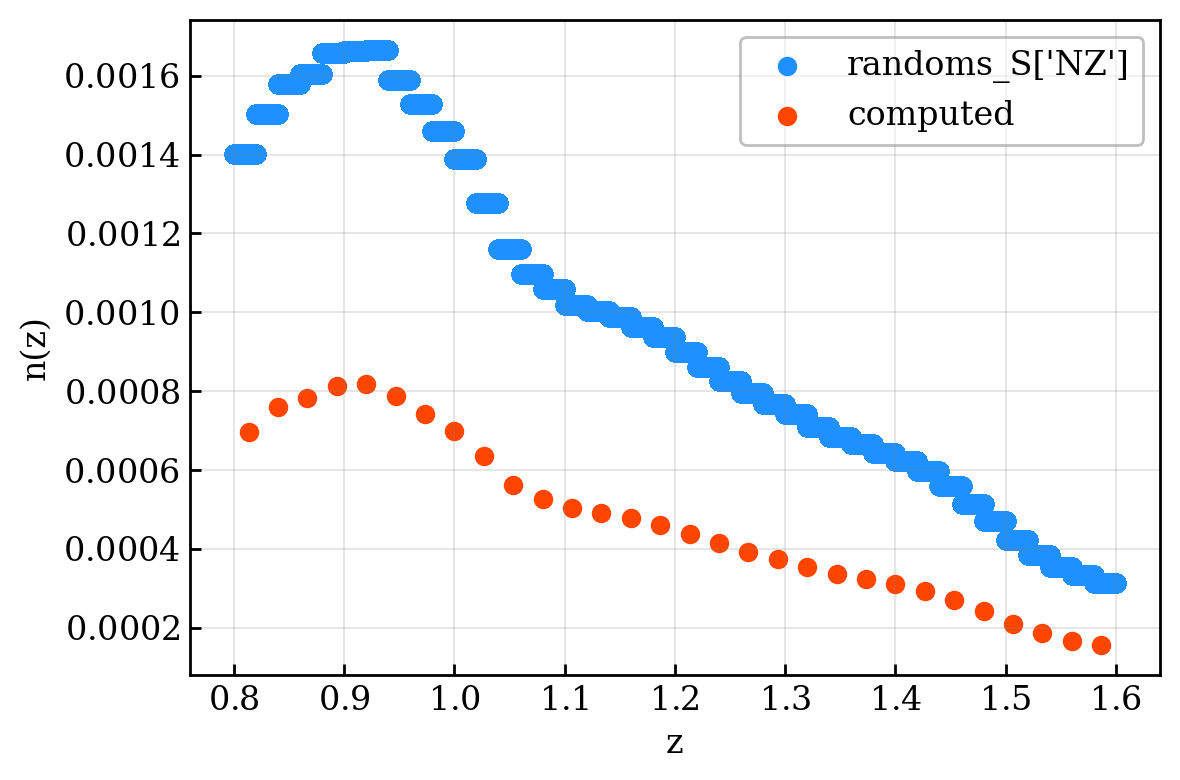

In [20]:
plt.scatter(randoms_S['Z'][::10], randoms_S['NZ'][::10], label='randoms_S[\'NZ\']')
plt.scatter(density.z, density.nbar, label='computed')
plt.legend()
plt.xlabel('z')
plt.ylabel('n(z)')
plt.show()